### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector

# Bank Marketing

## 1) Business Understanding
### Objective:
#### The goal is to predict whether a customer will subscribe to a term deposit (target variable) based on various features (e.g., age, job, balance). The bank wants to optimize its marketing strategy by focusing on customers most likely to subscribe.

### Key Questions:
#### What are the target market segment for the Portuguese banking institution, and what shoud be customer retention policies

### Success Criteria:
#### Provide options to the Portuguese banking institution to optimize its marketing strategies, reduce costs, and increase the conversion rates of their marketing campaigns, thereby improving overall profitability

## 2) Data Understanding

Objective: Familiarize with the dataset, understand the features, and assess the target variable.

## 2.1 Data Collection

The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed.

In [3]:

# Fetch the dataset
bank_marketing = fetch_ucirepo(id=222)

  
# data (as pandas dataframes) 
df = pd.DataFrame(bank_marketing.data.features)
df['target'] = bank_marketing.data.targets 


# Display the first few rows and basic information
print(df.shape)
print(df.head())
print(df.info())
print(df['target'].value_counts())  # Check the distribution of the target variable


(45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  \
0     NaN            5   may       261         1     -1         0      NaN   
1     NaN            5   may       151         1     -1         0      NaN   
2     NaN            5   may        76         1     -1         0      NaN   
3     NaN            5   may        92         1     -1         0      NaN   
4     NaN            5   may       198         1     -1         0      NaN   

  target  
0     no  
1     no  
2     no  
3     no  
4     no  
<class '

Total number of dataset : 45,211

Total number of features : 16

Target variable : has the client subscribed a term deposit? (binary: "yes","no")

## 2.2 Exploratory Data Analysis (EDA)

In [4]:
# To make data exploration easy for the first iteration, I am just loading 10,00 random rows into a dataframe

customer_sample = df.sample(n=10000)

# Explore the dataset
print(customer_sample.head())
print(customer_sample.info())
print(customer_sample.describe())


       age          job  marital  education default  balance housing loan  \
4373    51   management  married        NaN      no     6482     yes   no   
38949   57       admin.  married  secondary      no      403     yes   no   
28684   36   unemployed  married  secondary      no      -35      no   no   
30136   33  blue-collar  married  secondary      no      315      no   no   
44594   34   technician   single   tertiary      no     2481      no   no   

        contact  day_of_week month  duration  campaign  pdays  previous  \
4373        NaN           19   may       182         2     -1         0   
38949  cellular           18   may       603         1    340         2   
28684  cellular           30   jan       339         3     -1         0   
30136  cellular            4   feb       146         3     -1         0   
44594  cellular           23   aug       220        16    192        14   

      poutcome target  
4373       NaN     no  
38949    other    yes  
28684      NaN

## 3 Prepeare the data for modelling

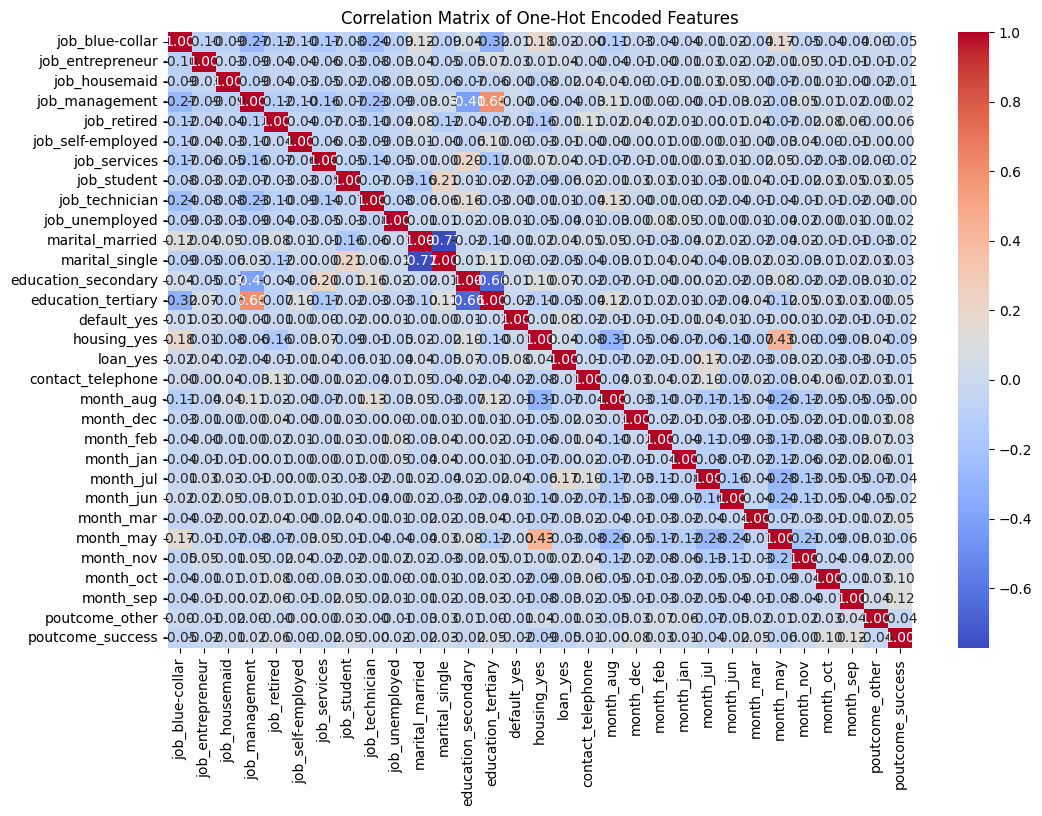

<Figure size 640x480 with 0 Axes>

In [5]:
# Perform Collinearity Test
# handle categorical variables, scaling numerical features, and splitting the data.
    
# Split the data into features and target
X_corr = df.drop('target', axis=1)
y_corr = df['target']

# Identify categorical and numerical features
categorical_features = X_corr.select_dtypes(include=['object']).columns
numerical_features = X_corr.select_dtypes(exclude=['object']).columns

### Check for Collinearity Among Categorical Variables

# Convert categorical variables to dummy/indicator variables (for correlation check)
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_dummies.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of One-Hot Encoded Features')
plt.show()
plt.savefig('images/Correlation_Matrix.jpg')


In [6]:
# based on the above Correlation, choose the below features

new_categorical_features = ['loan','housing','default','education','job', 'marital', 'education']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(drop='first'), new_categorical_features)  # One-Hot encode categorical features
    ]
)

# Fit and transform the data
X_encoded = preprocessor.fit_transform(df.drop('target', axis=1))

# Convert to DataFrame for easy interpretation
X_model = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names_out())
y_model = df['target'].values

# Display the encoded DataFrame
print(X_model.head())

# Split the data

X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

#### Here is the final trained model. We will continue to use this going forward
print(X_train_model)

   num__age  num__balance  num__day_of_week  num__duration  num__campaign  \
0  1.606965      0.256419         -1.298476       0.011016      -0.569351   
1  0.288529     -0.437895         -1.298476      -0.416127      -0.569351   
2 -0.747384     -0.446762         -1.298476      -0.707361      -0.569351   
3  0.571051      0.047205         -1.298476      -0.645231      -0.569351   
4 -0.747384     -0.447091         -1.298476      -0.233620      -0.569351   

   num__pdays  num__previous  cat__loan_yes  cat__housing_yes  \
0   -0.411453       -0.25194            0.0               1.0   
1   -0.411453       -0.25194            0.0               1.0   
2   -0.411453       -0.25194            1.0               1.0   
3   -0.411453       -0.25194            0.0               1.0   
4   -0.411453       -0.25194            0.0               0.0   

   cat__default_yes  ...  cat__job_services  cat__job_student  \
0               0.0  ...                0.0               0.0   
1               

# 4. Modeling

In [ ]:
# Perform Classification modelling for K-Nearest Neighbors, Logistic Regression, Decision Tree and Support Vector Machine
# Later I will only continue with the most accurate model
# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

# Store results
results = {}

# Evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('classifier', clf)
    ])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train_model, y_train_model)
    
    # Make predictions on the test data
    y_pred_model = pipeline.predict(X_test_model)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test_model, y_pred_model)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_model, y_pred_model))
    
    # Store the results
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test_model, y_pred_model, output_dict=True)
    }
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap='Blues')

    # Show the plot
    plt.title('Confusion Matrix for' + f"{name})
    plt.show()


In [16]:
# Plot the data using Plotly

data = {
    'Model': ['K-Nearest Neighbors', 'Logistic Regression', 'Decision Tree', 'Support Vector Machine'],
    'Accuracy': [0.8822, 0.8881, 0.8528, 0.8900],
    'Precision': [0.72, 0.75, 0.66, 0.76],
    'Recall': [0.63, 0.60, 0.66, 0.60],
    'F1-Score': [0.66, 0.63, 0.66, 0.63]
}

df_results_comparision = pd.DataFrame(data)
df_results_comparision


,Model,Accuracy,Precision,Recall,F1-Score
0,K-Nearest Neighbors,0.8822,0.72,0.63,0.66
1,Logistic Regression,0.8881,0.75,0.60,0.63
2,Decision Tree,0.8528,0.66,0.66,0.66
3,Support Vector Machine,0.8900,0.76,0.60,0.63


# 5. Evaluation

In [17]:
# Compare the performance of the models using various metrics.

K-Nearest Neighbors - Accuracy: 0.8822
Logistic Regression - Accuracy: 0.8881
Decision Tree - Accuracy: 0.8560
Support Vector Machine - Accuracy: 0.8900


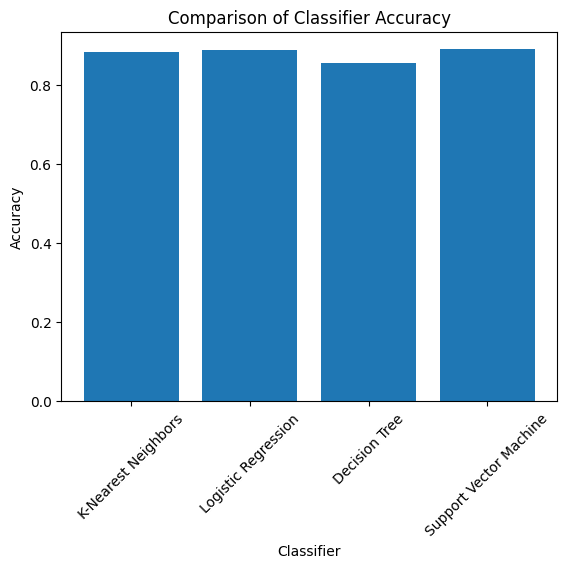

<Figure size 640x480 with 0 Axes>

In [18]:
# Compare accuracies
for name, result in results.items():
    print(f"{name} - Accuracy: {result['accuracy']:.4f}")

# Optionally, plot the accuracies
accuracies = [results[name]['accuracy'] for name in classifiers.keys()]
plt.bar(classifiers.keys(), accuracies)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Comparison of Classifier Accuracy')
plt.xticks(rotation=45)
plt.show()
plt.savefig('images/compare_accuracy.jpg')

### 5.1 Cross-Validation

Using cross-validation, we can further assess the model's generalization performance. Cross-validation provides a more reliable estimate of a model's performance on unseen data by averaging results over multiple folds.

In [20]:
from sklearn.model_selection import cross_val_score

# Function to evaluate overfitting
def evaluate_overfitting(model, X_train, X_test, y_train, y_test):
    # Training score
    train_score = model.score(X_train, y_train)
    
    # Test score
    test_score = model.score(X_test, y_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=2)
    cv_mean = cv_scores.mean()
    
    print(f"Training Accuracy: {train_score:.4f}")
    print(f"Test Accuracy: {test_score:.4f}")
    print(f"Cross-Validation Accuracy (mean of 5 folds): {cv_mean:.4f}")
    
    if train_score > test_score + 0.1:
        print("Potential overfitting detected: Training accuracy significantly higher than test accuracy.")
    elif test_score > train_score:
        print("Model is underfitting: Test accuracy is higher than training accuracy.")
    else:
        print("Model is performing consistently between training and test sets.")

        
# Evaluate all classifiers
for name, clf in classifiers.items():
    print(f"\nEvaluating {name}...")
    
    # Create a pipeline with preprocessing and the classifier
    model_cv = Pipeline(steps=[
        ('classifier', clf)
    ])
    
    # Fit the model on the training data
    model_cv.fit(X_train_model, y_train_model)
    
    # Evaluate overfitting
    evaluate_overfitting(model_cv, X_train_model, X_test_model, y_train_model, y_test_model)



Evaluating K-Nearest Neighbors...
Training Accuracy: 0.9153
Test Accuracy: 0.8822
Cross-Validation Accuracy (mean of 5 folds): 0.8870
Model is performing consistently between training and test sets.

Evaluating Logistic Regression...
Training Accuracy: 0.8922
Test Accuracy: 0.8881
Cross-Validation Accuracy (mean of 5 folds): 0.8919
Model is performing consistently between training and test sets.

Evaluating Decision Tree...
Training Accuracy: 1.0000
Test Accuracy: 0.8550
Cross-Validation Accuracy (mean of 5 folds): 0.8553
Potential overfitting detected: Training accuracy significantly higher than test accuracy.

Evaluating Support Vector Machine...
Training Accuracy: 0.9020
Test Accuracy: 0.8900
Cross-Validation Accuracy (mean of 5 folds): 0.8928
Model is performing consistently between training and test sets.


# 6 Interpretation of Results

In [ ]:
# Compute the confusion matrix
# Evaluate all classifiers
for name, clf in classifiers.items():
    print(f"\nEvaluating {name}...")
    
    # Create a pipeline with preprocessing and the classifier
    model_conf = Pipeline(steps=[
        ('classifier', clf)
    ])
    
    # Fit the model on the training data
    model_conf.fit(X_train_model, y_train_model)
    cm = confusion_matrix(y_test_model, y_pred_model, labels=pipeline.classes_)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap='Blues')

# Show the plot
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Visualize the classification methods with Support Vector Machine only

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


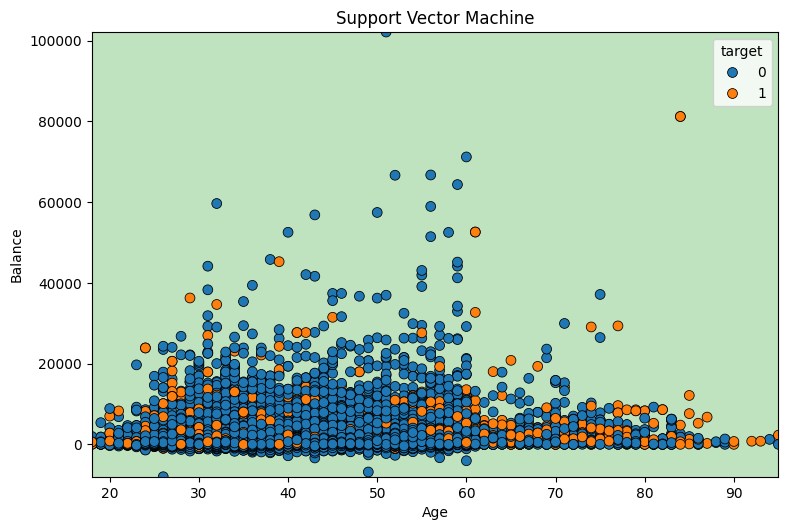

In [42]:
# Select two features for visualization
selected_features = ['age', 'balance']
X = df[selected_features]
y = df['target']

# Encode categorical target
y = y.map({'no': 0, 'yes': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'Support Vector Machine': SVC(kernel='linear')
}

# Prepare the grid for visualization
xx = np.linspace(X_train['age'].min(), X_train['age'].max(), 50)
yy = np.linspace(X_train['balance'].min(), X_train['balance'].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]

# Set up the plot
plt.figure(figsize=(15, 10))

# Visualize each classifier's decision boundary
for i, (name, clf) in enumerate(classifiers.items()):
    plt.subplot(2, 2, i + 1)
    
    # Create a pipeline for each classifier
    model = make_pipeline(StandardScaler(), clf)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict labels for the grid
    labels = model.predict(grid)
    
    # Plot decision boundary
    plt.contourf(XX, YY, labels.reshape(XX.shape), cmap='tab10', alpha=0.3)
    
    # Plot training points
    sns.scatterplot(data=X_train, x='age', y='balance', hue=y_train, palette='tab10', edgecolor='k', s=50)
    
    # Set plot title and labels
    plt.title(f"{name}")
    plt.xlabel('Age')
    plt.ylabel('Balance')

plt.tight_layout()
plt.show()
#plt.save

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


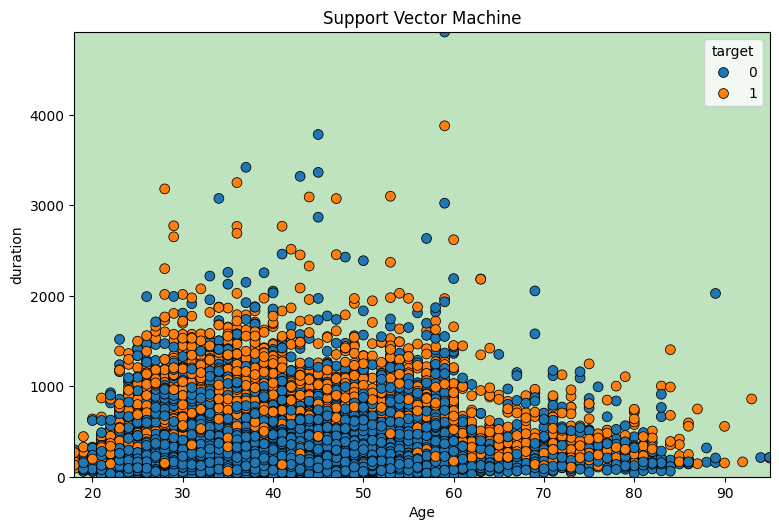

In [43]:
# Select two features for visualization
selected_features = ['age', 'duration']
X = df[selected_features]
X.dropna()
y = df['target']

# Encode categorical target
y = y.map({'no': 0, 'yes': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'Support Vector Machine': SVC(kernel='linear')
}

# Prepare the grid for visualization
xx = np.linspace(X_train['age'].min(), X_train['age'].max(), 50)
yy = np.linspace(X_train['duration'].min(), X_train['duration'].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]

# Set up the plot
plt.figure(figsize=(15, 10))

# Visualize each classifier's decision boundary
for i, (name, clf) in enumerate(classifiers.items()):
    plt.subplot(2, 2, i + 1)
    
    # Create a pipeline for each classifier
    model = make_pipeline(StandardScaler(), clf)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict labels for the grid
    labels = model.predict(grid)
    
    # Plot decision boundary
    plt.contourf(XX, YY, labels.reshape(XX.shape), cmap='tab10', alpha=0.3)
    
    # Plot training points
    sns.scatterplot(data=X_train, x='age', y='duration', hue=y_train, palette='tab10', edgecolor='k', s=50)
    
    # Set plot title and labels
    plt.title(f"{name}")
    plt.xlabel('Age')
    plt.ylabel('duration')

plt.tight_layout()
plt.show()
#plt.save

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

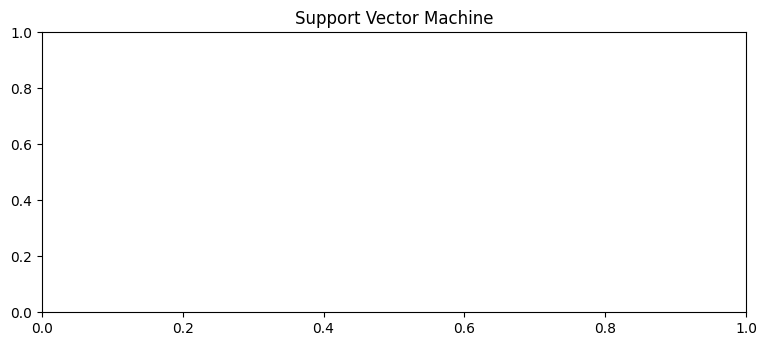

In [50]:
# Plot decision boundaries
plt.figure(figsize=(20, 8))

for i, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train_model, y_train_model)
    ax = plt.subplot(2, 2, i + 1)
    plt.title(name)
    plt.scatter(X_train_model.iloc[:, 1], X_train_model.iloc[:, 2], c=y_train_model, cmap=plt.cm.coolwarm)
    plt.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)

plt.tight_layout()
plt.show()

### 7 Features with significant impact:

In [ ]:
from sklearn.inspection import permutation_importance

# Train the SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to display the feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

In [ ]:
from sklearn.inspection import permutation_importance
# Evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipeline_pi = Pipeline(steps=[
        ('classifier', clf)
    ])
    
    # Fit the pipeline to the training data
    pipeline_pi.fit(X_train_model, y_train_model)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(pipeline_pi, X_test_model, y_test_model, n_repeats=10, random_state=42)

    # Create a DataFrame to display the feature importance
    importance_df = pd.DataFrame({
        'Feature': preprocessor.get_feature_names_out(),
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Display the feature importance
    print(importance_df)

## 8 Conclusions

The goal was to build and evaluate several classification models to predict customer responses (e.g., whether a customer would subscribe to a term deposit) based on various features in the Bank Marketing dataset.

My analysis found Support Vector Machine as the most accurate and efficient clasification model.

Factors such as Job status seems to be the target personas while calling a prospect and convincing him/her for a term deposit in the first call.
